In [1]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.linear_gaussian_ssm.inference import lgssm_smoother
from dynamax.linear_gaussian_ssm.models.linear_gaussian_ssm import LinearGaussianSSM

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Generate synthetic data and initilize parameter using EM algorithm

100%|██████████| 100/100 [00:01<00:00, 60.01it/s]


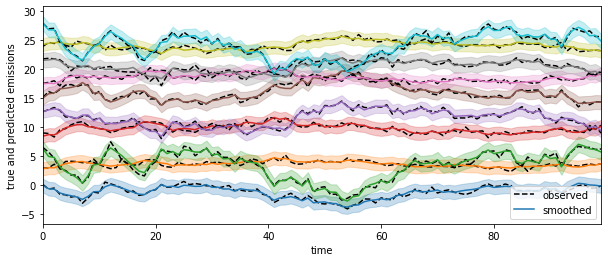

In [2]:
# Simulate synthetic data from true model
state_dim = 2
emission_dim = 10
num_timesteps = 100
keys = map(jr.PRNGKey, count())

true_model = LinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.random_initialization(next(keys))
true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps)

# Initilize parameters by fitting EM algorithm
num_iters = 100
test_model = LinearGaussianSSM(state_dim, emission_dim)
initial_params, param_props = test_model.random_initialization(next(keys))
fitted_params, marginal_lls = test_model.fit_em(initial_params, param_props, emissions, num_iters=num_iters)

# Extract fitted params
fitted_C = fitted_params['emissions']['weights']
fitted_d = fitted_params['emissions']['bias']
fitted_R = fitted_params['emissions']['cov']

# Compute predicted emissions
posterior = test_model.smoother(fitted_params, emissions)
smoothed_emissions = posterior.smoothed_means @ fitted_C.T + fitted_d
smoothed_emissions_cov = fitted_C @ posterior.smoothed_covariances @ fitted_C.T + fitted_R
smoothed_emissions_std = jnp.sqrt(
    jnp.array([smoothed_emissions_cov[:, i, i] for i in range(emission_dim)]))

# Plot the fitted model
spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions[:, i] - 2 * jnp.sqrt(smoothed_emissions_std[i]),
        spc * i + smoothed_emissions[:, i] + 2 * jnp.sqrt(smoothed_emissions_std[i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()

### Sample parameters using HMC

In [3]:
sample_size = 500
param_samples, lps = test_model.fit_hmc(initial_params, param_props, next(keys), sample_size, emissions, num_integration_steps=30)

/Users/scott/Projects/dynamax-main/dynamax/abstractions.py:234: UserWarning: HMC is not currently computing logdets of the constrainer jacobians!
  warn("HMC is not currently computing logdets of the constrainer jacobians!")


Running window adaptation


100%|██████████| 500/500 [00:40<00:00, 12.21it/s]


Text(0.5, 0, 'log probability')

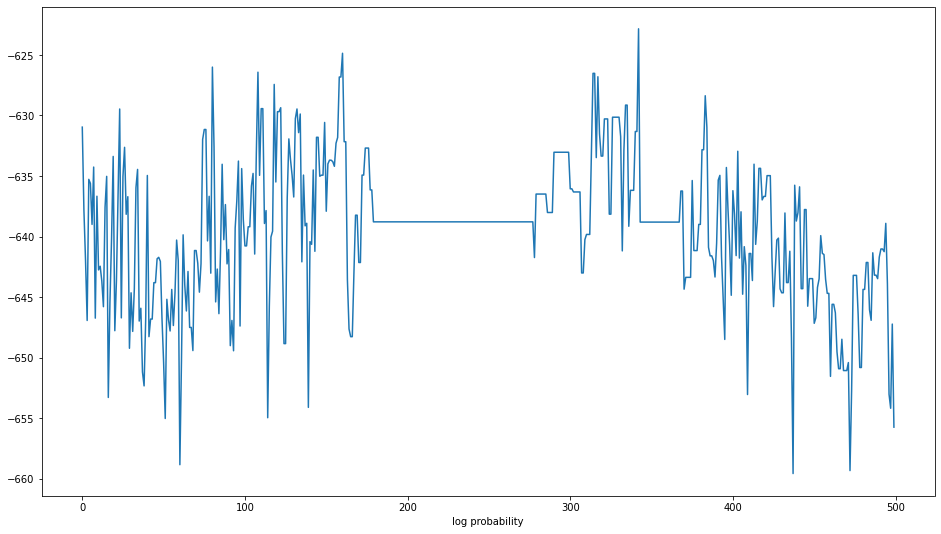

In [4]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

In [5]:
@jit
def smooth_emission(params):
    C = params['emissions']['weights']
    d = params['emissions']['bias']
    posterior = test_model.smoother(params, emissions)
    return posterior.smoothed_means @ C.T + d

smoothed_emissions = vmap(smooth_emission)(param_samples)
smoothed_emissions_means = smoothed_emissions.mean(axis=0)
smoothed_emissions_stds = jnp.std(smoothed_emissions, axis=0)

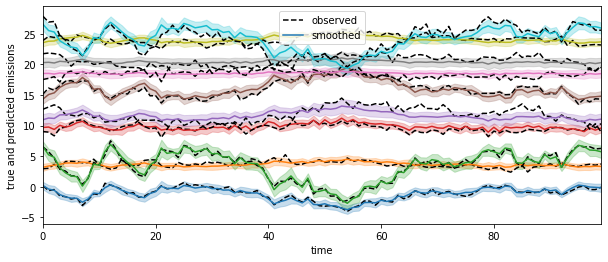

In [6]:
spc = 3
plt.figure(figsize=(10, 4))
for i in range(emission_dim):
    plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
    ln = plt.plot(smoothed_emissions_means[:, i] + spc * i,
                  label="smoothed" if i == 0 else None)[0]
    plt.fill_between(
        jnp.arange(num_timesteps),
        spc * i + smoothed_emissions_means[:, i] - 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        spc * i + smoothed_emissions_means[:, i] + 2 * jnp.sqrt(smoothed_emissions_stds[:, i]),
        color=ln.get_color(),
        alpha=0.25,
    )
plt.xlabel("time")
plt.xlim(0, num_timesteps - 1)
plt.ylabel("true and predicted emissions")
plt.legend()